---
title: Transforming workflow for oeanography study using S2 data, from SAFE to ZARR
subtitle: Computing wave 
authors:
  - name: Tina Odaka
    orcid: 0000-0002-1500-0156
    github: tinaok
    affiliations:
      - id: IFREMER
        institution: IFREMER
        ror: 044jxhp58
  - name: Anne Fouilloux
    orcid: 0000-0002-1784-2920
    github: annefou
    affiliations:
      - id: Simula Research Laboratory
        institution: Simula Research Laboratory
        ror: 00vn06n10
date: 2025-01-29
thumbnail: https://raw.githubusercontent.com/EOPF-Sample-Service/eopf-sample-notebooks/refs/heads/main/notebooks/static/ESA_logo_2020_Deep.png
keywords: ["oceanography", "wave analysis", "remote sensing"]
tags: ["oceanography", "spectral analysis", "Sentinel-2"]
releaseDate: 2025-07-29
datePublished: 2025-07-29
dateModified: 2025-07-30
github: https://github.com/EOPF-Sample-Service/eopf-sample-notebooks
license: Apache-2.0
---

```{image} ../static/ESA_EOPF_logo_2025_COLOR_ESA_blue_reduced.png
:alt: ESA EOPF Zarr Logo
:width: 250px
:align: center
```

## Table of contents

- [Introduction](#Introduction)

- [Setup](#Setup)

- [Access the Analysisi Ready Clowed Optimised EOPF ZARR  file](#Read)


(Intro)=
## Introduction

This notebook demonstrates an improved workflow for oceanographic wave spectral analysis using Sentinel-2 data. We transition from the traditional SAFE format to the cloud-optimized EOPF Zarr format, highlighting substantial improvements in computational efficiency, simplicity, and scalability.

Original research workflow based on SAFE format is available at [this notebook](https://github.com/tinaok/eopf-webiner6/blob/main/SAFE_workflow.ipynb).

To understand the scientific background for the wave analysis methods used here, refer to:
[Cuevas et al., 2016](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2016JC012425).

This workflow leverages the new EOPF Zarr format, eliminating the cumbersome steps required for loading SAFE files, significantly simplifying data handling and computational processing.



## Objectives

- Demonstrate the efficiency and ease of use of the EOPF Zarr format compared to SAFE.
- Perform advanced wave spectral analysis using Sentinel-2 data.
- Illustrate scientific procedures clearly with reproducible examples.


:::{hint} Overview
**Questions**
- What is the original workflow does?
- What is needed to make use of EOPF ZARR?
- 

**Objectives**
- Objective 1
- Objective 2
:::


## Setup

We start by importing essential Python libraries for wave analysis, data visualization, and handling xarray datasets efficiently.


In [1]:
#!pip install hvplot datashader

In [1]:
import xarray as xr
import hvplot.xarray
import pystac_client
import holoviews as hv
import numpy as np

import matplotlib.pyplot as plt
from skimage.filters import sobel
from skimage.filters import threshold_otsu
from scipy.ndimage import gaussian_filter
import matplotlib.colors as mcolors


## Accessing Sentinel-2 Data in EOPF Zarr Format

We use the cloud-optimized EOPF Zarr format available through the [EOPF Sample Service](https://eopf-sample-service.github.io/eopf-sample-notebooks/stac-eopf-zarr-sentinel).

This notebook closely matches the geographic coordinates and time from the original SAFE workflow notebook to facilitate direct comparison.


In [2]:
#lets try to specify 'ocean' point and see if we have any specific metadta to collect 'ocean' parts from stac catalog,

catalog = pystac_client.Client.open("https://stac.core.eopf.eodc.eu")
LON, LAT = -4.5, 48

date = "2025-06-17/2025-06-17"

collections=['sentinel-2-l1c','sentinel-2-l2a']
# Search with cloud cover filter
items = list(
    catalog.search(
        datetime=date,
        collections=collections,
    intersects=dict(type="Point", coordinates=[LON, LAT]),
        query={
            "eo:cloud_cover": {"lt": 20},
            "view:sun_elevation": {"lt": 27},
        },
    ).items()
)

for item in items:
        print(f"✅ {item.id}")


✅ S2B_MSIL2A_20250617T112109_N0511_R037_T30UUU_20250617T133829
✅ S2B_MSIL1C_20250617T112109_N0511_R037_T30UUU_20250617T131418



### Loading Sentinel-2 Data Using xarray

The EOPF Zarr format allows us to efficiently access Sentinel-2 Level-1C (L1C) and Level-2A (L2A) data. For demonstration, we initially load the L2A data to quickly verify the location and cloud conditions, then proceed with detailed analysis using L1C data.

This step replaces the previous complicated rasterio-based custom scripts required for SAFE files, drastically simplifying the data access process.


In [3]:
item = items[0]  # extracting the first item , S2L2A(S2B_MSIL2A_20250617T112109_N0511_R037_T30UUU_20250617T133829)

l2a = xr.open_dataset(
    item.assets["product"].href,
    **item.assets["product"].extra_fields["xarray:open_datatree_kwargs"],
)#.persist()    
l2a_plot=l2a.quality_l2a_quicklook_r60m_tci.hvplot.rgb(x='quality_l2a_quicklook_r60m_x',
                                              y='quality_l2a_quicklook_r60m_y',
                                              bands='quality_l2a_quicklook_r60m_band',
                                              aspect='equal', 
                                              rasterize=True,
                                             )
#l2a_plot

/srv/conda/envs/notebook/lib/python3.12/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: Engine 'kerchunk' loading failed:
No module named 'zarr.core.array_spec'; 'zarr.core' is not a package
  external_backend_entrypoints = backends_dict_from_pkg(entrypoints_unique)


### Opening Sentinel-2 L1C Data in Xarray Format Using the EOPF Backend

We begin by working on an ocean scene with low cloud coverage—ideal for analyzing wave spectra.

We load item[1], which provides access to the Sentinel-2 L1C product.

In the example above, we used open_dataset, which leverages the xarray-eopf backend. This backend reads the EOPF Zarr format from disk, where data is internally structured as a datatree. While datatrees provide a well-organized hierarchy, they can require more navigation (“clicking”) to inspect individual components.

However, when using open_dataset, the essential datasets are exposed directly at the top level, making them more accessible for analysis.

For advanced Sentinel-2 users: if you can’t locate specific information using open_dataset, try using open_datatree to explore the full hierarchical structure of the dataset.

In [4]:
item = items[1]  # extracting the second item S2L1C (S2B_MSIL1C_20250617T112109_N0511_R037_T30UUU_20250617T131418)

l1c_original = xr.open_datatree(
    item.assets["product"].href,
    **item.assets["product"].extra_fields["xarray:open_datatree_kwargs"],
)#.persist()  
l1c_original

<xarray.DataTree>
Group: /
│   Attributes: (3)
├── Group: /conditions
│   ├── Group: /conditions/geometry
│   │       Dimensions:                        (angle: 2, band: 13, y: 23, x: 23,
│   │                                           detector: 7)
│   │       Coordinates:
│   │         * angle                          (angle) <U7 56B 'zenith' 'azimuth'
│   │         * band                           (band) <U3 156B 'b01' 'b02' ... 'b11' 'b12'
│   │         * detector                       (detector) int64 56B 3 4 5 6 7 8 9
│   │         * x                              (x) int64 184B 300000 305000 ... 410000
│   │         * y                              (y) int64 184B 5400000 5395000 ... 5290000
│   │       Data variables:
│   │           mean_sun_angles                (angle) float64 16B dask.array<chunksize=(2,), meta=np.ndarray>
│   │           mean_viewing_incidence_angles  (band, angle) float64 208B dask.array<chunksize=(13, 2), meta=np.ndarray>
│   │           sun_angles                     (angle, y, x) float64 8kB dask.array<chunksize=(2, 23, 23), meta=np.ndarray>
│   │           viewing_incidence_angles       (band, detector, angle, y, x) float64 770kB dask.array<chunksize=(7, 4, 2, 23, 23), meta=np.ndarray>
│   ├── Group: /conditions/mask
│   │   ├── Group: /conditions/mask/detector_footprint
│   │   │   ├── Group: /conditions/mask/detector_footprint/r10m
│   │   │   │       Dimensions:  (y: 10980, x: 10980)
│   │   │   │       Coordinates:
│   │   │   │         * x        (x) int64 88kB 300005 300015 300025 300035 ... 409775 409785 409795
│   │   │   │         * y        (y) int64 88kB 5399995 5399985 5399975 ... 5290225 5290215 5290205
│   │   │   │       Data variables:
│   │   │   │           b02      (y, x) uint8 121MB dask.array<chunksize=(10980, 10980), meta=np.ndarray>
│   │   │   │           b03      (y, x) uint8 121MB dask.array<chunksize=(10980, 10980), meta=np.ndarray>
│   │   │   │           b04      (y, x) uint8 121MB dask.array<chunksize=(10980, 10980), meta=np.ndarray>
│   │   │   │           b08      (y, x) uint8 121MB dask.array<chunksize=(10980, 10980), meta=np.ndarray>
│   │   │   ├── Group: /conditions/mask/detector_footprint/r20m
│   │   │   │       Dimensions:  (y: 5490, x: 5490)
│   │   │   │       Coordinates:
│   │   │   │         * x        (x) int64 44kB 300010 300030 300050 300070 ... 409750 409770 409790
│   │   │   │         * y        (y) int64 44kB 5399990 5399970 5399950 ... 5290250 5290230 5290210
│   │   │   │       Data variables:
│   │   │   │           b05      (y, x) uint8 30MB dask.array<chunksize=(5490, 5490), meta=np.ndarray>
│   │   │   │           b06      (y, x) uint8 30MB dask.array<chunksize=(5490, 5490), meta=np.ndarray>
│   │   │   │           b07      (y, x) uint8 30MB dask.array<chunksize=(5490, 5490), meta=np.ndarray>
│   │   │   │           b11      (y, x) uint8 30MB dask.array<chunksize=(5490, 5490), meta=np.ndarray>
│   │   │   │           b12      (y, x) uint8 30MB dask.array<chunksize=(5490, 5490), meta=np.ndarray>
│   │   │   │           b8a      (y, x) uint8 30MB dask.array<chunksize=(5490, 5490), meta=np.ndarray>
│   │   │   └── Group: /conditions/mask/detector_footprint/r60m
│   │   │           Dimensions:  (y: 1830, x: 1830)
│   │   │           Coordinates:
│   │   │             * x        (x) int64 15kB 300030 300090 300150 300210 ... 409650 409710 409770
│   │   │             * y        (y) int64 15kB 5399970 5399910 5399850 ... 5290350 5290290 5290230
│   │   │           Data variables:
│   │   │               b01      (y, x) uint8 3MB dask.array<chunksize=(1830, 1830), meta=np.ndarray>
│   │   │               b09      (y, x) uint8 3MB dask.array<chunksize=(1830, 1830), meta=np.ndarray>
│   │   │               b10      (y, x) uint8 3MB dask.array<chunksize=(1830, 1830), meta=np.ndarray>
│   │   └── Group: /conditions/mask/l1c_classification
│   │       └── Group: /conditions/mask/l1c_classification/r60m
│   │               Dimensions:  (y: 1830, x: 18

### Detector Identification

Sentinel-2 imagery is collected by multiple detectors, each capturing different swaths of the Earth's surface. Accurate spectral wave analysis requires selecting consistent data from a single detector to ensure spatial coherence.

Here, we visualize the detector footprints to ensure consistent and accurate data selection.

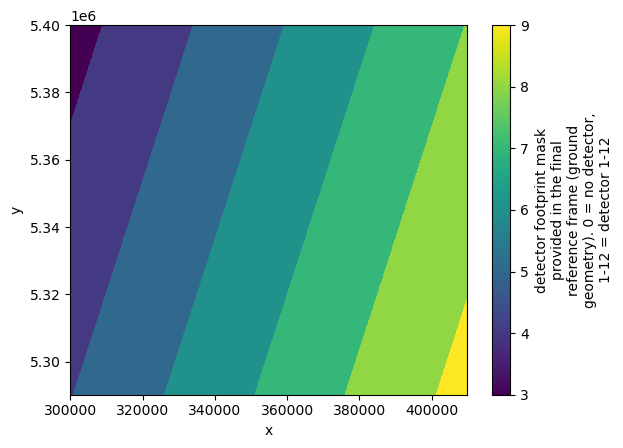

In [5]:
l1c_original['conditions']['mask']['detector_footprint']['r60m'].b09.plot()

### Selecting a Region and Verifying Detector Consistency

We focus our analysis on bands B04 and B02, which are available at 10 m spatial resolution in Sentinel-2 L1C products.

A 5 km × 5 km area of interest was manually selected using the UTM grid. To ensure accurate wave spectrum computation, we verify that the selected region in both bands corresponds to the same detector.

This verification step helps ensure consistency in viewing geometry. We also visualize the selected bands to inspect reflectance values before proceeding with spectral analysis.

In [6]:
# Define patch size in meters
size = 5000  

# Ocean location example: (change minx to switch to land)
minx = 352_305
maxy = 5_350_005

# Bounding box corners
maxx = minx + size
miny = maxy - size

# Draw UTM bounding box using HoloViews
box = hv.Rectangles([(minx, miny, maxx, maxy)]).opts(
    line_color='white',
    line_width=1,
    fill_alpha=0
)

print("Selected UTM coordinates:", minx, maxx, maxy, miny)

# Use quicklook image to extract coordinate axes
xr_obj = l1c_original['quality']['l1c_quicklook']['r10m']
x = xr_obj.x
y = xr_obj.y

# Convert UTM coords to array indices
x0 = x.get_index('x').get_loc(minx)
x1 = x.get_index('x').get_loc(maxx)
y0 = y.get_index('y').get_loc(maxy)
y1 = y.get_index('y').get_loc(miny)

print("Index bounds in image array:", x0, x1, y0, y1)

# Translate indices to "boxi" convention (for software like S2_read)
col_start = x0
row_start = xr_obj.x.size - y1
row_end = row_start + (y1 - y0)

boxi = [col_start, x1, row_start, row_end]
print("Corresponding boxi for S2_read:", boxi)

# Overlay selected region on RGB quicklook
l2a_plot * box

Selected UTM coordinates: 352305 357305 5350005 5345005
Index bounds in image array: 5230 5730 4999 5499
Corresponding boxi for S2_read: [5230, 5730, 5481, 5981]


:DynamicMap   []
   :Overlay
      .RGB.I        :RGB   [quality_l2a_quicklook_r60m_x,quality_l2a_quicklook_r60m_y]   (R,G,B)
      .Rectangles.I :Rectangles   [x0,y0,x1,y1]

In [7]:
#clip out l1c with above defind mix and miny
l1c=l1c_original.sel(x=slice(minx,maxx-1),y=slice(miny,maxy-1, -1))
l1c

<xarray.DataTree>
Group: /
│   Attributes: (3)
├── Group: /conditions
│   ├── Group: /conditions/geometry
│   │       Dimensions:                        (angle: 2, band: 13, y: 1, x: 1, detector: 7)
│   │       Coordinates:
│   │         * angle                          (angle) <U7 56B 'zenith' 'azimuth'
│   │         * band                           (band) <U3 156B 'b01' 'b02' ... 'b11' 'b12'
│   │         * detector                       (detector) int64 56B 3 4 5 6 7 8 9
│   │         * x                              (x) int64 8B 355000
│   │         * y                              (y) int64 8B 5350000
│   │       Data variables:
│   │           mean_sun_angles                (angle) float64 16B dask.array<chunksize=(2,), meta=np.ndarray>
│   │           mean_viewing_incidence_angles  (band, angle) float64 208B dask.array<chunksize=(13, 2), meta=np.ndarray>
│   │           sun_angles                     (angle, y, x) float64 16B dask.array<chunksize=(2, 1, 1), meta=np.ndarray>
│   │           viewing_incidence_angles       (band, detector, angle, y, x) float64 1kB dask.array<chunksize=(7, 4, 2, 1, 1), meta=np.ndarray>
│   ├── Group: /conditions/mask
│   │   ├── Group: /conditions/mask/detector_footprint
│   │   │   ├── Group: /conditions/mask/detector_footprint/r10m
│   │   │   │       Dimensions:  (y: 500, x: 500)
│   │   │   │       Coordinates:
│   │   │   │         * x        (x) int64 4kB 352305 352315 352325 352335 ... 357275 357285 357295
│   │   │   │         * y        (y) int64 4kB 5345005 5345015 5345025 ... 5349975 5349985 5349995
│   │   │   │       Data variables:
│   │   │   │           b02      (y, x) uint8 250kB dask.array<chunksize=(500, 500), meta=np.ndarray>
│   │   │   │           b03      (y, x) uint8 250kB dask.array<chunksize=(500, 500), meta=np.ndarray>
│   │   │   │           b04      (y, x) uint8 250kB dask.array<chunksize=(500, 500), meta=np.ndarray>
│   │   │   │           b08      (y, x) uint8 250kB dask.array<chunksize=(500, 500), meta=np.ndarray>
│   │   │   ├── Group: /conditions/mask/detector_footprint/r20m
│   │   │   │       Dimensions:  (y: 250, x: 250)
│   │   │   │       Coordinates:
│   │   │   │         * x        (x) int64 2kB 352310 352330 352350 352370 ... 357250 357270 357290
│   │   │   │         * y        (y) int64 2kB 5345010 5345030 5345050 ... 5349950 5349970 5349990
│   │   │   │       Data variables:
│   │   │   │           b05      (y, x) uint8 62kB dask.array<chunksize=(250, 250), meta=np.ndarray>
│   │   │   │           b06      (y, x) uint8 62kB dask.array<chunksize=(250, 250), meta=np.ndarray>
│   │   │   │           b07      (y, x) uint8 62kB dask.array<chunksize=(250, 250), meta=np.ndarray>
│   │   │   │           b11      (y, x) uint8 62kB dask.array<chunksize=(250, 250), meta=np.ndarray>
│   │   │   │           b12      (y, x) uint8 62kB dask.array<chunksize=(250, 250), meta=np.ndarray>
│   │   │   │           b8a      (y, x) uint8 62kB dask.array<chunksize=(250, 250), meta=np.ndarray>
│   │   │   └── Group: /conditions/mask/detector_footprint/r60m
│   │   │           Dimensions:  (y: 84, x: 83)
│   │   │           Coordinates:
│   │   │             * x        (x) int64 664B 352350 352410 352470 352530 ... 357150 357210 357270
│   │   │             * y        (y) int64 672B 5345010 5345070 5345130 ... 5349870 5349930 5349990
│   │   │           Data variables:
│   │   │               b01      (y, x) uint8 7kB dask.array<chunksize=(84, 83), meta=np.ndarray>
│   │   │               b09      (y, x) uint8 7kB dask.array<chunksize=(84, 83), meta=np.ndarray>
│   │   │               b10      (y, x) uint8 7kB dask.array<chunksize=(84, 83), meta=np.ndarray>
│   │   └── Group: /conditions/mask/l1c_classification
│   │       └── Group: /conditions/mask/l1c_classification/r60m
│   │               Dimensions:  (y: 84, x: 83)
│   │               Coordinates:
│   │                 * x        (x) int64 664B 352350 352410 352470 352530 ... 357150 357210 357270
│   │             

In [9]:
#The S2 code plot in x and y  in y and x direftion and flipping y axis..

(l1c
    #['quality']['l1c_quicklook']['r10m'].tci
    ['measurements']['reflectance']['r10m'].b04
    .hvplot
 #   .rgb
 (x='y',
                                              y='x',
  #                                            bands='band',
                                              aspect='equal', 
                                              rasterize=True,
  flip_yaxis=True, cmap='jet'
                                             )
)


:DynamicMap   []
   :Image   [y,x]   (TOA reflectance from MSI acquisition at spectral band b04 665.0 nm)

Lets verify if all the data we cropped are from the same detector. 

In [8]:
#verify that all information is from same detector.  
b04_detector = l1c['conditions']['mask']['detector_footprint']['r10m']['b04'].astype(int)

detector = np.unique(b04_detector.values)


if len(detector) > 1:
    raise ValueError(f"b04_detector is not uniq! : {detector}")
else:
    detector=detector[0]
    print(f"✅ : The clipped domain is all in a same detector: {detector}")
    

✅ : The clipped domain is all in a same detector: 6


## Image Normalization and Whitecap Filtering

In this section, we extract and normalize the B04 and B02 bands from the Sentinel-2 Level-1C reflectance data, and then apply an edge-based filtering (Sobel + threshold) to reduce the influence of whitecaps (i.e., foam-related reflectance artifacts).

Band Selection

We work with:
- B04 (red) and
- B02 (blue)

Both are available at 10 m resolution:

In [9]:
# original notebook, b04  is indicated as img1, b02 is indicated as img2
#  x and y are inversed at the point of loading dataset. So we inverse the data
#  as in the original workflow using transpose. 


b04=l1c['measurements']['reflectance']['r10m'].b04
b02=l1c['measurements']['reflectance']['r10m'].b02

### Median Normalization and Axis Transposition

As per the original workflow, the X and Y axes are transposed to match image orientation conventions.

In [ ]:
# normalizes the image values, and inverse x & Y


# Normalize by median and transpose (Y, X -> X, Y)
img1 = np.transpose((b04 / np.median(b04.values.flatten())).compute().values)
img2 = np.transpose((b02 / np.median(b02.values.flatten())).compute().values)

# Plot B04
plt.imshow(np.flipud(np.transpose(img1)), vmin=0.9, vmax=1.1, )#cmap='gray')
plt.colorbar()
plt.title("Normalized B04")
plt.show()

# Plot B02
plt.imshow(np.flipud(np.transpose(img2)), vmin=0.9, vmax=1.1, )#cmap='gray')
plt.colorbar()
plt.title("Normalized B02")
plt.show()

### Sobel Filtering and Whitecap Masking

We apply the Sobel operator to both images to highlight intensity gradients (edges), typically corresponding to whitecaps or strong reflectance structures. Then, a 95th percentile threshold is used to mask out strong-gradient regions.

In [ ]:
# Compute Sobel gradients
gradient_sobel1 = sobel(img1)
gradient_sobel2 = sobel(img2)

# Plot Sobel gradient of B02
plt.figure(figsize=(8, 4))
plt.imshow(gradient_sobel2, cmap="gist_gray_r", origin="upper")
plt.colorbar(label="Gradient amplitude")
plt.title("Edge Detection (Sobel) - B02")
plt.show()

# Threshold (95th percentile)
threshold1 = np.percentile(gradient_sobel1, 95)
threshold2 = np.percentile(gradient_sobel2, 95)

# Binary mask: retain only low-gradient (non-whitecap) regions
mask1 = gradient_sobel1 < threshold1
mask2 = gradient_sobel2 < threshold2

# Apply masks: replace high-gradient areas with NaN
filtered_image1 = np.where(mask1, img1, np.nan)
filtered_image2 = np.where(mask2, img2, np.nan)

# Plot the filtered image (B04)
plt.figure(figsize=(8, 4))
plt.imshow(np.flipud(np.transpose(filtered_image1)), cmap="viridis", vmin=0.9, vmax=1.1, origin="upper")
plt.colorbar(label="Filtered Reflectance")
plt.title("Filtered B04 (Sobel + Threshold)")
plt.savefig('img1_filtered.png')
plt.show()

### Pixel Value Distribution (Histogram)

We visualize the intensity distribution of the normalized reflectance values for bands B04 and B02 using histograms. This step helps verify that the normalization behaves consistently across the two channels and that there are no outliers or saturation artifacts before spectral processing.

In [ ]:
# Display the histogram of values for the original image
plt.figure(figsize=(6, 4))
plt.hist(img1.ravel(), bins=100, color='blue', alpha=0.7, label='b04')
plt.hist(img2.ravel(), bins=100, color='red', alpha=0.7, label='b02')
plt.xlabel("Values of pixels")
plt.ylabel("Fréquency")
plt.title("Histogramme intensity")
plt.legend()
plt.show()


### Fourier Transform & Welch-Based Spectral Analysis

This section demonstrates a two-dimensional Fast Fourier Transform (FFT) analysis on paired Sentinel‑2 images (e.g., bands B02 and B04). The core function, `FFT2D_two_arrays_nonan`, is adapted directly from the original research implementation and follows a Welch-style spectral estimation.

### Overview of the Processing Steps:
1. **Image Tiling**: The images are partitioned into overlapping tiles configured by `ntile`.
2. **NaN Handling**: Within each tile, any NaN values (e.g., from filtering or masking) are replaced by the local tile mean. Tiles containing more than 50 % NaNs are excluded.
3. **Windowing**: A 2D Hanning window is applied to each tile to minimize edge artifacts and spectral leakage.
4. **FFT Execution**: FFT is computed for each windowed tile, and the resulting power spectra are accumulated.
5. **Spectrum Averaging**: Averaging across all tiles (standard Welch method) enhances spectral stability and reduces noise.

### Output Metrics:
- `Eta`, `Etb`: Power spectral density (PSD) for each image
- `coh`: Spectral coherence between the two images
- `ang`: Phase difference (in radians)
- `crosr`: Real part of the cross‑spectrum
- `kx2`, `ky2`: Spatial frequency coordinates (cycles per meter)
- `dkxtile`, `dkytile`: Frequency resolution in both axes

In [69]:
def FFT2D_two_arrays_nonan(arraya, arrayb, dx, dy, n, isplot=False):
    """
    Performs a Welch-method 2D FFT spectral analysis on two input arrays.

    Input:
      arraya, arrayb : 2D float arrays (same shape)
      dx, dy         : spatial resolution of pixels (m)
      n              : tile division factor (uses n^2 + (n-1)^2 overlapping tiles)
      isplot         : if True, visualizes tile layout

    Output:
      Eta, Etb       : PSDs for arraya/arrayb
      ang            : phase difference between cross-spectra
      angstd         : phase standard deviation across tiles
      coh            : spectral coherence
      crosr          : real component of the cross-spectrum
      kx2, ky2       : wavenumber meshgrid (cycles/m)
      dkxtile, dkytile: frequency resolution
    """

    nxa, nya = arraya.shape
    mspec = n**2 + (n-1)**2
    nxtile, nytile = nxa // n, nya // n
    dkxtile = 1 / (dx * nxtile)
    dkytile = 1 / (dy * nytile)
    shx, shy = nxtile // 2, nytile // 2

    # Build kx, ky frequency axes
    kx = np.fft.fftshift(np.fft.fftfreq(nxtile, dx))
    ky = np.fft.fftshift(np.fft.fftfreq(nytile, dy))
    kx2, ky2 = np.meshgrid(kx, ky, indexing='ij')

    wx = 0.5 * (1 - np.cos(2 * np.pi * np.arange(nxtile)/(nxtile-1)))
    wy = 0.5 * (1 - np.cos(2 * np.pi * np.arange(nytile)/(nytile-1)))
    window2d = np.outer(wx, wy)
    norm_factor = (1/np.mean(wx**2) * 1/np.mean(wy**2)) / (dkxtile * dkytile)

    Eta = np.zeros((nxtile, nytile))
    Etb = np.zeros((nxtile, nytile))
    phase_acc = np.zeros((nxtile, nytile), dtype=np.complex128)
    phases = np.zeros((nxtile, nytile, mspec), dtype=np.complex128)

    nspec = 0
    for m in range(mspec):
        if m < n**2:
            i1, i2 = divmod(m, n)
            ix1, ix2 = i1 * nxtile, (i1 + 1) * nxtile - 1
            iy1, iy2 = i2 * nytile, (i2 + 1) * nytile - 1
        else:
            idx = m - n**2
            i1, i2 = divmod(idx, n-1)
            ix1 = i1 * nxtile + shx
            iy1 = i2 * nytile + shy
            ix2 = ix1 + nxtile - 1
            iy2 = iy1 + nytile - 1

        tileA = arraya[ix1:ix2+1, iy1:iy2+1].astype(np.float64)
        tileB = arrayb[ix1:ix2+1, iy1:iy2+1].astype(np.float64)

        # Fill NaNs with tile mean
        for tile in (tileA, tileB):
            if np.isnan(tile).any():
                tile[np.isnan(tile)] = np.nanmean(tile)

        # Skip tiles with excessive NaNs
        if np.isnan(tileA).mean() > 0.5 or np.isnan(tileB).mean() > 0.5:
            continue

        FA = np.fft.fftshift(np.fft.fft2((tileA - tileA.mean()) * window2d, norm='forward'))
        FB = np.fft.fftshift(np.fft.fft2((tileB - tileB.mean()) * window2d, norm='forward'))

        Eta += np.abs(FA)**2 * norm_factor
        Etb += np.abs(FB)**2 * norm_factor
        phase_acc += FB * np.conj(FA) * norm_factor
        phases[:, :, nspec] = (FB * np.conj(FA)) / (np.abs(FA) * np.abs(FB))
        nspec += 1

    Eta /= nspec
    Etb /= nspec
    coh = np.abs(phase_acc / nspec)**2 / (Eta * Etb)
    ang = np.angle(phase_acc / nspec)
    crosr = np.real(phase_acc) / mspec
    angstd = np.std(np.angle(phases), axis=2)

    return Eta, Etb, ang, angstd, coh, crosr, phases, kx2, ky2, dkxtile, dkytile


    # resolution of B02, B04 is 10 m
dx = dy = 10  


(nx,ny)=img1.shape

ntile=16
(Eta,Etb,ang,angstd,coh,crosr,phases,kx2,ky2,dkx,dky)=FFT2D_two_arrays_nonan(
    filtered_image1,filtered_image2,dx,dy,ntile,isplot=0)

print(np.shape(Eta))
print(np.shape(kx2))
print(np.shape(ky2))

(31, 31)
(31, 31)
(31, 31)


## 📐 Computing Viewing Geometry: Sun and View Angles

We want to extract sun and viewing angles from the Sentinel-2 L1C data product and compute relevant angular quantities such as phase angles or off-specular angles. These metrics help understand the scattering geometry at the selected region (e.g., for ocean wave analysis).

### 🌞 Accessing the Angle Data

The full datatree contains the geometry metadata:


In [73]:
#(l1c_original['conditions']['geometry']['sun_angles'].hvplot(x='x',y='y' )
#+l1c_original['conditions']['geometry']['viewing_incidence_angles'].hvplot(x='x',y='y' )
#).cols(1)

In [22]:
sun_angles = l1c['conditions']['geometry']['sun_angles']
view_angles = l1c['conditions']['geometry']['viewing_incidence_angles']  
print(sun_angles.compute().values, view_angles.sel(detector=detector, band='b02').compute().values)


[[[ 27.0145]]

 [[152.472 ]]] [[[ 1.13787]]

 [[89.3232 ]]]


Since we’ve already clipped the image for our region of interest, we only extract the angles for this subset. However, the sampling grid might not be perfectly centered, so we need to interpolate the angle fields at the center of our clipped region.

✂️ Determine the Center of the Clipped Region


But in our case, it is slightly be off the center of our image.  So let's get it interpolated. 

###  Interpolating and Analyzing Viewing Geometry from Sentinel-2 L1C Data
To extract sun and viewing angles at a specific location in the scene, convert them to Cartesian unit vectors, and compute derived angular metrics for scattering geometry analysis.

 Interpolating Angles at Arbitrary `(x, y)` Coordinates

In [23]:
x_val = (minx + maxx) / 2
y_val = (miny + maxy) / 2


def interpolate_angles_at_xy(x_val, y_val, angle_array):
    """
    Interpolate azimuth and zenith angles at (x, y) coordinates.

    Parameters:
        x_val (float): x coordinate
        y_val (float): y coordinate
        angle_array (xarray.DataArray): must have 'angle' dimension with 'zenith' and 'azimuth'

    Returns:
        xarray.DataArray: Interpolated angle array with dimensions (band, detector, angle)
    """
    angle_names = angle_array.angle.values
    if 'azimuth' not in angle_names or 'zenith' not in angle_names:
        raise ValueError("Missing 'azimuth' or 'zenith' in angle dimension.")

    zenith = angle_array.sel(angle='zenith').interp(x=x_val, y=y_val)
    azimuth = angle_array.sel(angle='azimuth')
    sin_az = np.sin(np.deg2rad(azimuth))
    cos_az = np.cos(np.deg2rad(azimuth))
    interp_sin = sin_az.interp(x=x_val, y=y_val)
    interp_cos = cos_az.interp(x=x_val, y=y_val)
    azimuth_corrected = (np.rad2deg(np.arctan2(interp_sin, interp_cos))) % 360

    result = xr.concat(
        [zenith.expand_dims(angle=['zenith']),
         azimuth_corrected.expand_dims(angle=['azimuth'])],
        dim='angle'
    )
    return result


view_angles = interpolate_angles_at_xy(x_val, y_val, l1c_original['conditions']['geometry']['viewing_incidence_angles'])
sun_angles = interpolate_angles_at_xy(x_val, y_val, l1c_original['conditions']['geometry']['sun_angles'])



Spherical to Cartesian Conversion

In [25]:
def sph2cart(angle_da):
    """
    Convert spherical angles to Cartesian unit vectors.

    Parameters:
        angle_da (xarray.DataArray): must have 'angle' = ['zenith', 'azimuth']

    Returns:
        xarray.DataArray: shape (..., cartesian) with cartesian = ['x', 'y', 'z']
    """
    theta = np.radians(angle_da.sel(angle='zenith'))
    phi = np.radians(angle_da.sel(angle='azimuth'))
    x = np.sin(theta) * np.sin(phi)
    y = np.sin(theta) * np.cos(phi)
    z = np.cos(theta)
    return xr.concat([x, y, z], dim='cartesian').assign_coords(cartesian=['x', 'y', 'z'])

In [26]:
# Compute Cartesian vectors
sunvec = sph2cart(sun_angles)
obsvec = sph2cart(view_angles)

 🔄 Mid-Vector and Normalization

In [27]:
midvec = obsvec + sunvec
midvec_norm = midvec / np.sqrt((midvec**2).sum('cartesian'))

 📐 Angular Metrics Computation

In [36]:
offspec = np.degrees(np.arccos(midvec_norm.sel(cartesian='z')))
phitrig = np.degrees(np.arctan2(midvec_norm.sel(cartesian='x'),
                                midvec_norm.sel(cartesian='y')))
thetav = np.degrees(np.arccos(obsvec.sel(cartesian='z')))
phitrig=phitrig.sel(detector=6, band=['b04','b02']).compute()
phitrig

<xarray.DataArray (band: 2)> Size: 16B
array([149.47993192, 150.32367791])
Coordinates:
  * band      (band) <U3 24B 'b04' 'b02'
    detector  int64 8B 6
    x         float64 8B 3.548e+05
    y         float64 8B 5.348e+06
    angle     <U6 24B 'zenith'

Then appply compute!|

In [34]:
phitrig=phitrig.values

In [70]:
phiblind1=phitrig[0].values+90.  # blind azimuth for B04
phiblind2=phitrig[1].values+90.  # blind azimuth for B02
kN=50
xkblind=[-1.4*kN*np.sin(np.radians(phiblind1)) , 1.4*kN*np.sin(np.radians(phiblind2))]
ykblind=[-1.4*kN*np.cos(np.radians(phiblind1)) , 1.4*kN*np.cos(np.radians(phiblind2))]
print(xkblind, ykblind)

[np.float64(60.30159381316901), np.float64(-60.81853346026498)] [np.float64(35.54880846936472), np.float64(-34.65697603286573)]



## 🌊 Fourier and Cross-Spectral Analysis with angular metrics.

Next part visualizes and analyzes spatial and spectral properties of satellite image data, particularly from optical bands such as Sentinel-2 B02 and B04. The key steps and their explanations are outlined below.

---

## 1. 📐 Coordinate Generation

```python
X = np.arange(0, nx*dx, dx)
Y = np.arange(0, ny*dy, dy)
```

- `X` and `Y` represent the physical grid (in meters) corresponding to pixel spacing `dx` and `dy`.
- They define the spatial extent for plotting.

---

## 2. 🖼️ Surface Image Plot

```python
axs[0].pcolormesh(X/1000, Y/1000, np.transpose(filtered_image1), cmap='seismic', ...)
```

- Displays the filtered satellite image ( band B04).
- Coordinates are converted to kilometers.
- `np.transpose` is used because NumPy arrays are (row, col) = (y, x), while `pcolormesh` expects (x, y).

---

## 3. 📊 Spectrum Plot

```python
axs[1].pcolormesh(kx2*1000, ky2*1000, 10*np.log10(Eta), ...)
```

- Shows the 2D Fourier spectrum of the image.
- `kx2`, `ky2` are spatial frequency axes (cycles/km).
- The spectrum is converted to dB scale.
- Black dashed lines (`xkblind`, `ykblind`) indicate blind directions or masked regions.

---

## 4. 🧮 Variance and Energy Check

```python
print(np.var(img1), np.sum(Eta)*dkx*dky)
```

- Compares spatial domain variance to spectral energy.
- A consistency check based on Parseval's theorem.

---

## 5. 🔗 Coherence Between Bands

```python
axs[0].pcolormesh(kx2*1000, ky2*1000, coh, ...)
```

- Coherence indicates phase similarity between two bands (e.g., B02 and B04).
- Values range from 0 (incoherent) to 1 (perfectly coherent).

---

## 6. 🔄 Cross-Spectrum Phase

```python
axs[1].pcolormesh(kx2*1000, ky2*1000, np.degrees(ang), ...)
```

- Displays the phase angle of the cross-spectrum between two bands.
- Indicates relative shifts between features in different spectral bands.

---

## 7. 📈 Real Part of Cross-Spectrum

```python
axs[0].pcolormesh(kx2*1000, ky2*1000, 10*np.log10(crosr), ...)
```

- Visualizes the real component of the cross-spectrum.
- Indicates which spatial frequencies are common across bands.

---

## ✅ Summary

This script performs comprehensive spectral analysis of satellite imagery by:

- Visualizing filtered spatial data
- Computing 2D Fourier spectra
- Quantifying inter-band similarity via coherence and cross-spectral phase
- Evaluating energy consistency between spatial and spectral domains

It is especially useful in oceanographic and Earth surface pattern studies (e.g., wave fields, vegetation patterns, surface roughness).



variance 1: 0.004566965349694442 sum of spectrum: 0.003969145049406068
variance 2: 0.0006696226322313454 sum of spectrum: 0.0005955796139226743


/tmp/ipykernel_76111/285110910.py:49: RuntimeWarning: invalid value encountered in log10
  im=axs[0].pcolormesh(kx2*1000,ky2*1000,10*np.log10((crosr)),norm = mcolors.Normalize(vmin=-30, vmax=20))


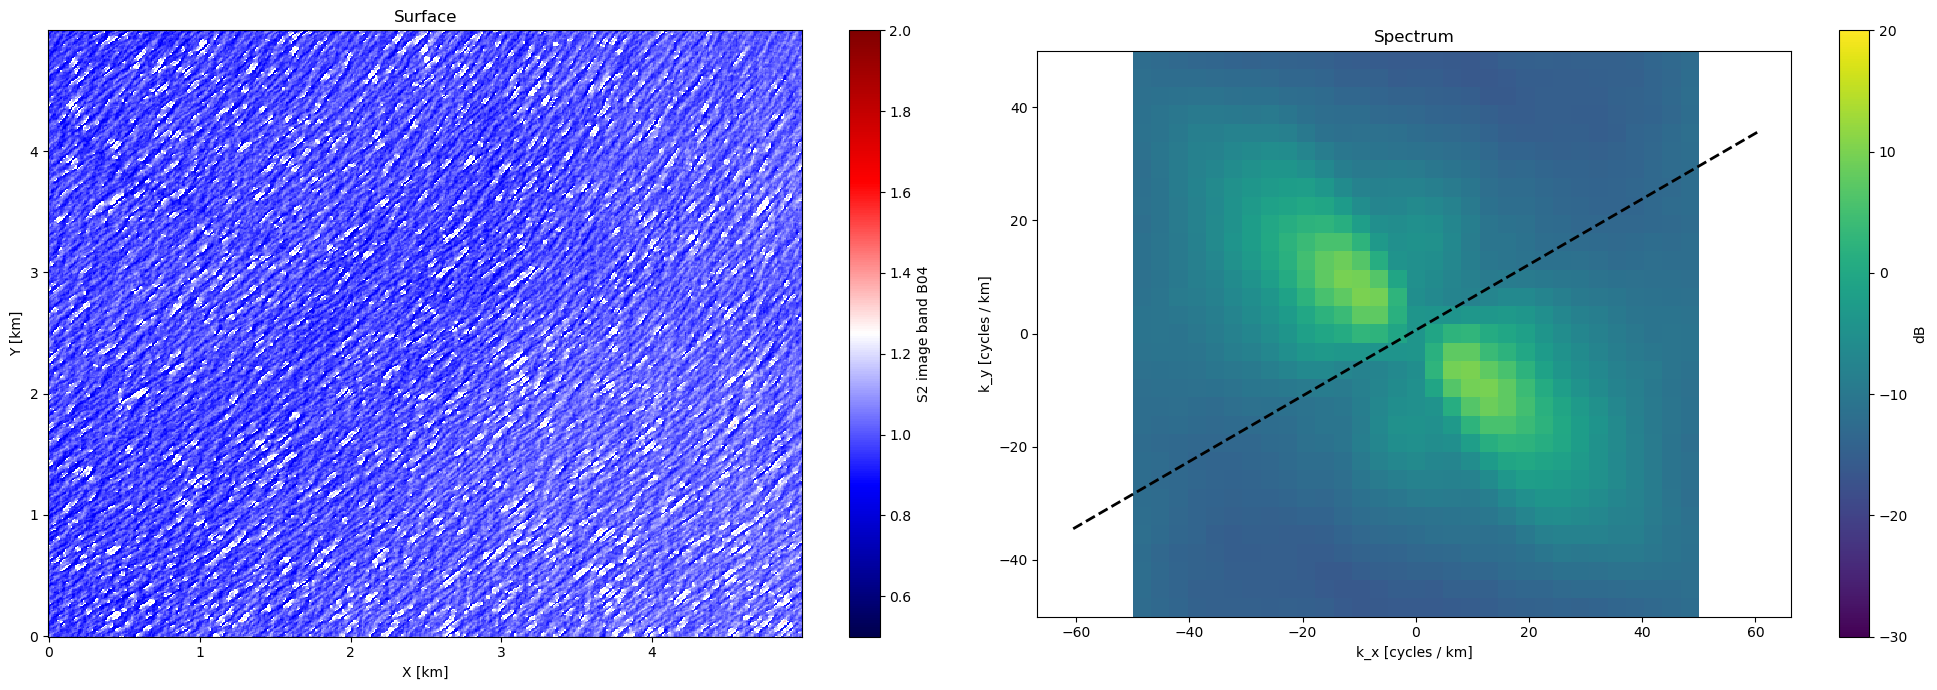

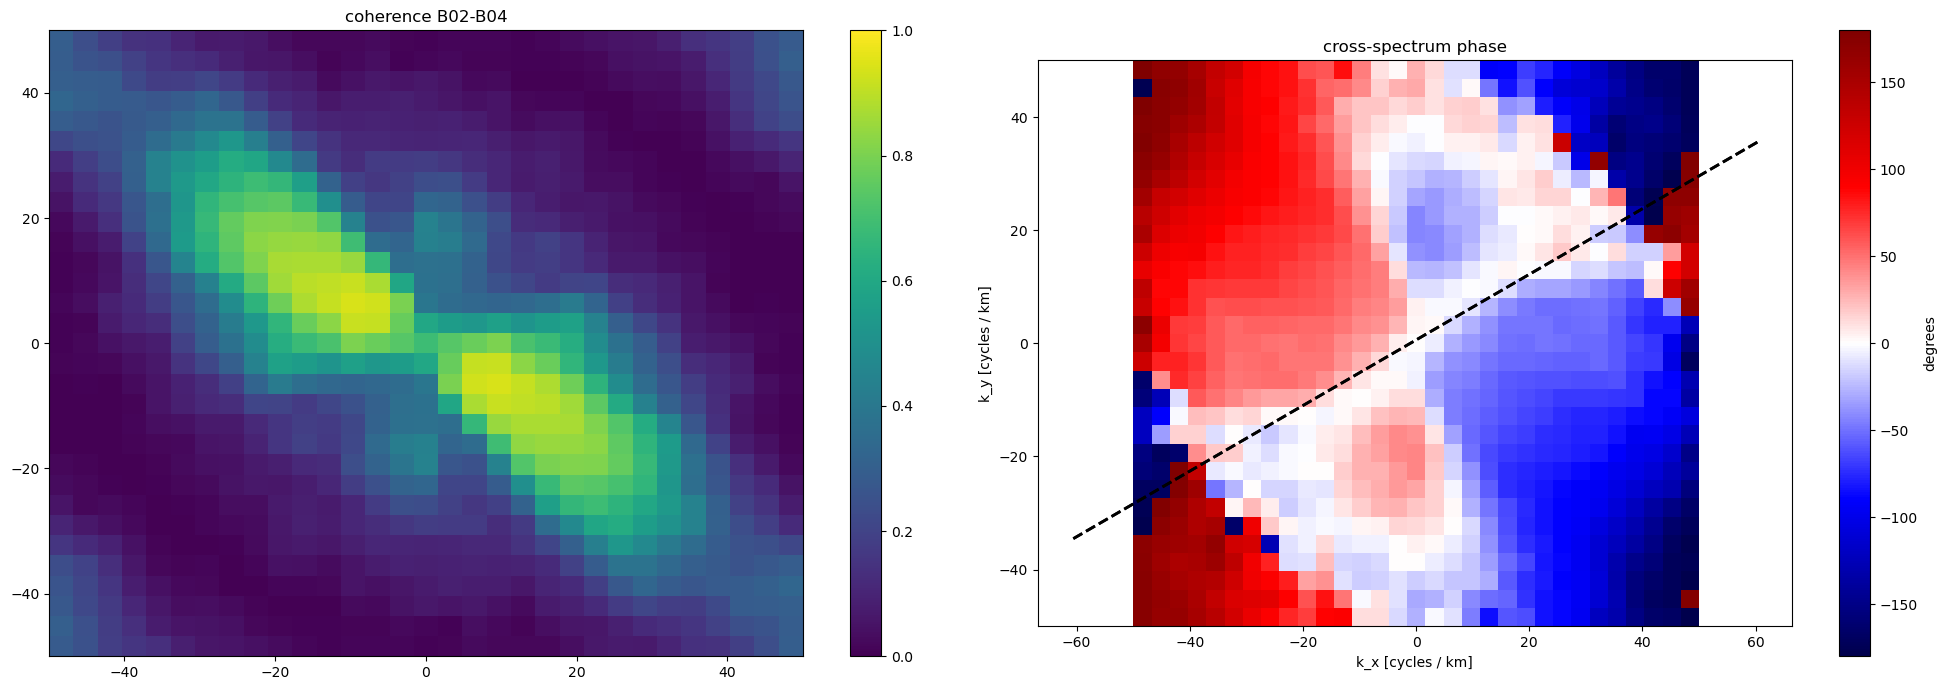

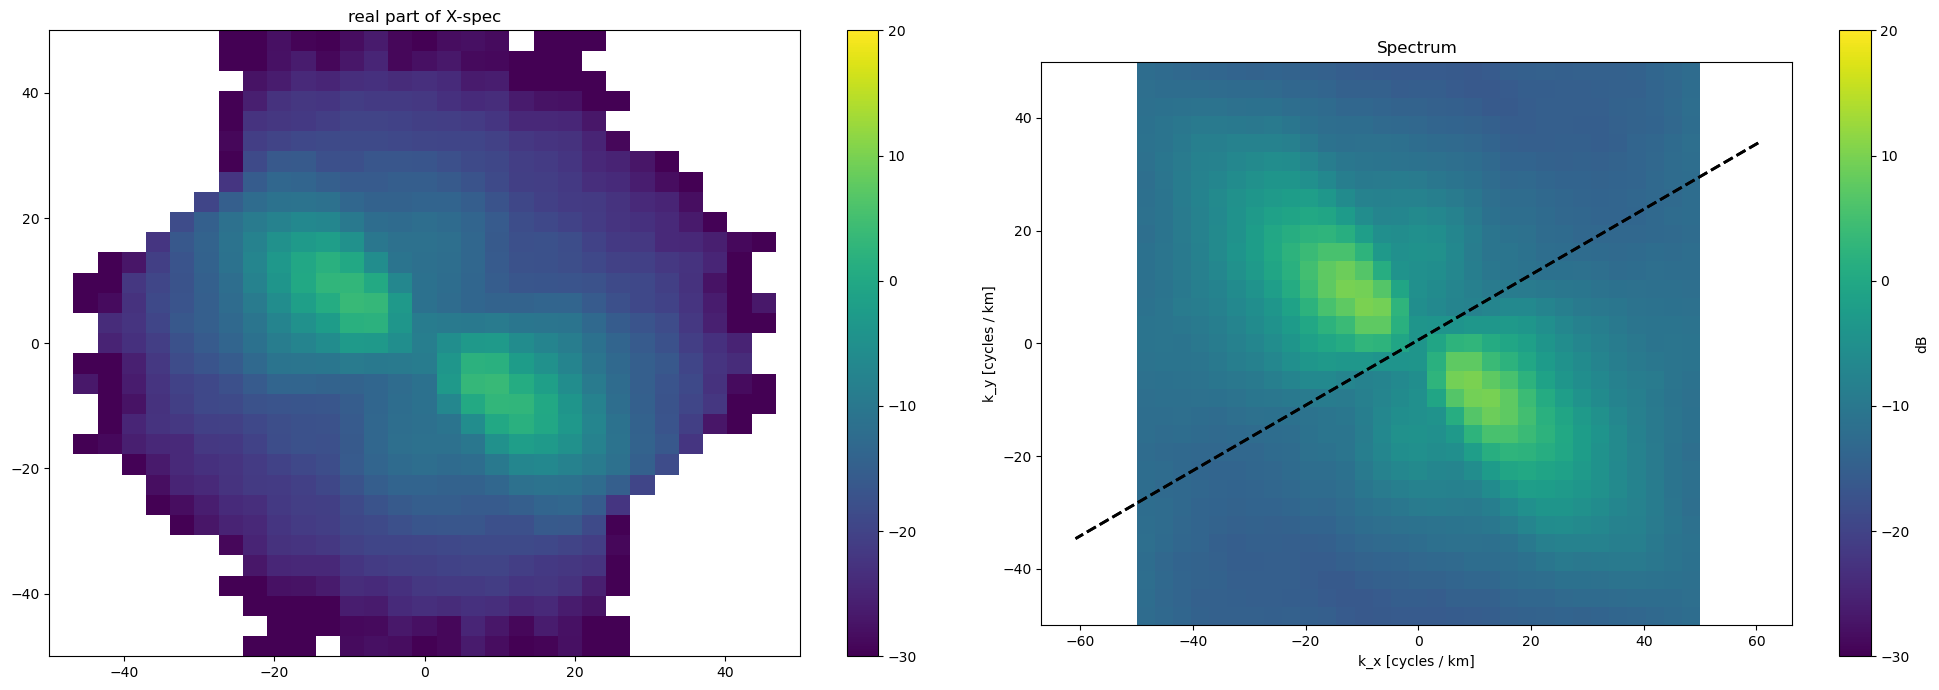

In [71]:
X = np.arange(0,nx*dx,dx) # from 0 to (nx-1)*dx with a dx step
Y = np.arange(0,ny*dy,dy)

fig,axs=plt.subplots(1,2,figsize=(20,7))#,sharey=True,sharex=True)
_=plt.gca().set_aspect('equal', adjustable='box')

# warning: we use an array img1 that is written with X in the first (number 0) dimension and Y in the second
#          but pcolormesh uses the opposite order: hence the use of transpose 

im=axs[0].pcolormesh(X/1000,Y/1000,np.transpose(filtered_image1),cmap='seismic',norm = mcolors.Normalize(vmin=0.5, vmax=2))
_=plt.colorbar(im,ax=axs[0],label='S2 image band B04')
_=axs[0].set_xlabel('X [km]')
_=axs[0].set_ylabel('Y [km]')
_=axs[0].set_title('Surface')

im=axs[1].pcolormesh(kx2*1000,ky2*1000,10*np.log10((Eta)),norm = mcolors.Normalize(vmin=-30, vmax=20))
_=plt.colorbar(im,ax=axs[1],label='dB')
_=plt.plot(xkblind,ykblind,color='k',linestyle='--',linewidth=2)
_=axs[1].set_xlabel('k_x [cycles / km]')
_=axs[1].set_ylabel('k_y [cycles / km]')
_=axs[1].set_title('Spectrum')
_=plt.tight_layout()

print('variance 1:',np.var(img1.flatten()), 'sum of spectrum:',np.sum(Eta.flatten())*dkx*dky )
print('variance 2:',np.var(img2.flatten()), 'sum of spectrum:',np.sum(Etb.flatten())*dkx*dky )


fig,axs=plt.subplots(1,2,figsize=(20,7))#,sharey=True,sharex=True)
_=plt.gca().set_aspect('equal', adjustable='box')

im=axs[0].pcolormesh(kx2*1000,ky2*1000,coh,norm = mcolors.Normalize(vmin=0, vmax=1))
_=plt.colorbar(im,ax=axs[0],label=' ')
_=plt.plot(xkblind,ykblind,color='k',linestyle='--',linewidth=2)
_=axs[1].set_xlabel('k_x [cycles / km]')
_=axs[1].set_ylabel('k_y [cycles / km]')
_=axs[0].set_title('coherence B02-B04')

im=axs[1].pcolormesh(kx2*1000,ky2*1000,np.degrees(ang),cmap='seismic',norm = mcolors.Normalize(vmin=-180, vmax=180))
_=plt.colorbar(im,ax=axs[1],label='degrees')
_=plt.plot(xkblind,ykblind,color='k',linestyle='--',linewidth=2)
_=axs[1].set_xlabel('k_x [cycles / km]')
_=axs[1].set_ylabel('k_y [cycles / km]')
_=axs[1].set_title('cross-spectrum phase')
_=plt.tight_layout()

fig,axs=plt.subplots(1,2,figsize=(20,7))#,sharey=True,sharex=True)
_=plt.gca().set_aspect('equal', adjustable='box')

im=axs[0].pcolormesh(kx2*1000,ky2*1000,10*np.log10((crosr)),norm = mcolors.Normalize(vmin=-30, vmax=20))
_=plt.colorbar(im,ax=axs[0],label=' ')
_=plt.plot(xkblind,ykblind,color='k',linestyle='--',linewidth=2)
_=axs[1].set_xlabel('k_x [cycles / km]')
_=axs[1].set_ylabel('k_y [cycles / km]')
_=axs[0].set_title('real part of X-spec')

im=axs[1].pcolormesh(kx2*1000,ky2*1000,10*np.log10((Eta)),norm = mcolors.Normalize(vmin=-30, vmax=20))
_=plt.colorbar(im,ax=axs[1],label='dB')
_=plt.plot(xkblind,ykblind,color='k',linestyle='--',linewidth=2)
_=axs[1].set_xlabel('k_x [cycles / km]')
_=axs[1].set_ylabel('k_y [cycles / km]')
_=axs[1].set_title('Spectrum')
_=plt.tight_layout()

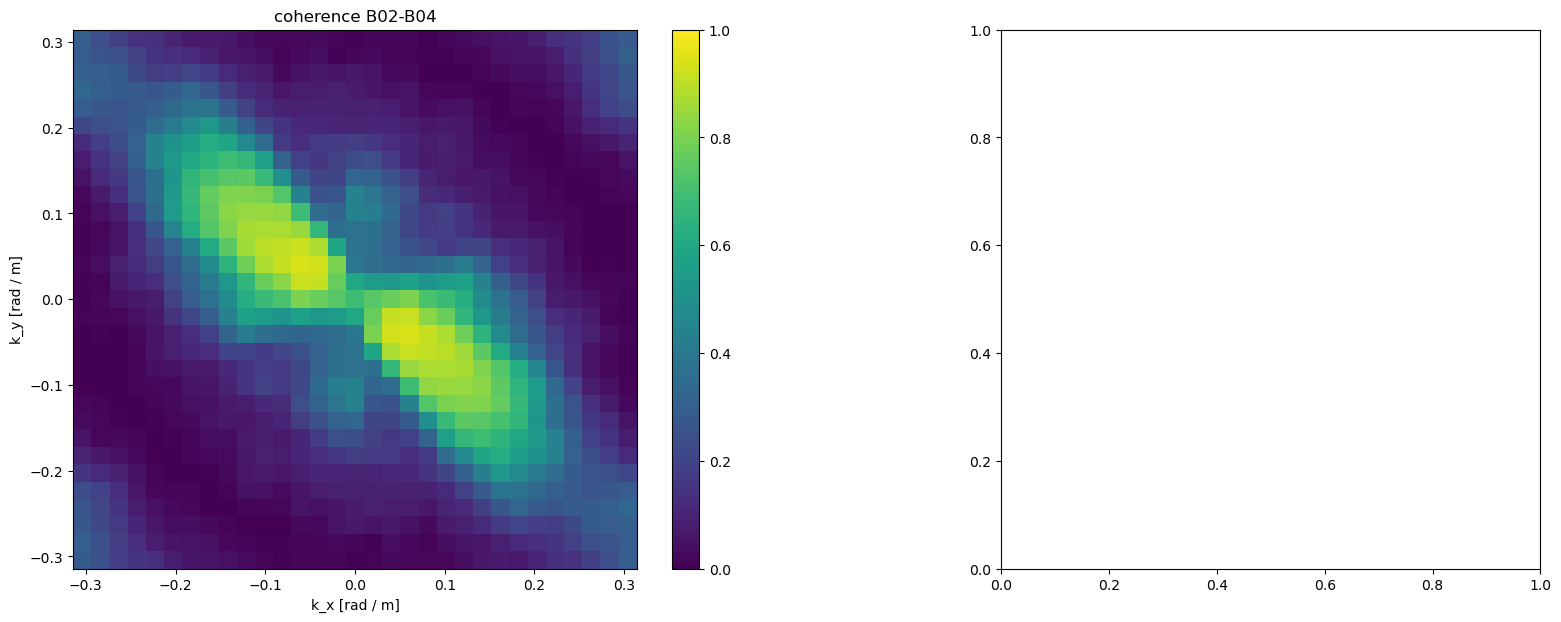

In [72]:
fig,axs=plt.subplots(1,2,figsize=(20,7))#,sharey=True,sharex=True)
_=plt.gca().set_aspect('equal', adjustable='box')

im=axs[0].pcolormesh(kx2*2*np.pi,ky2*2*np.pi,coh,norm = mcolors.Normalize(vmin=0, vmax=1))
_=plt.colorbar(im,ax=axs[0],label=' ')
_=axs[0].set_xlabel('k_x [rad / m]')
_=axs[0].set_ylabel('k_y [rad / m]')
_=axs[0].set_title('coherence B02-B04')


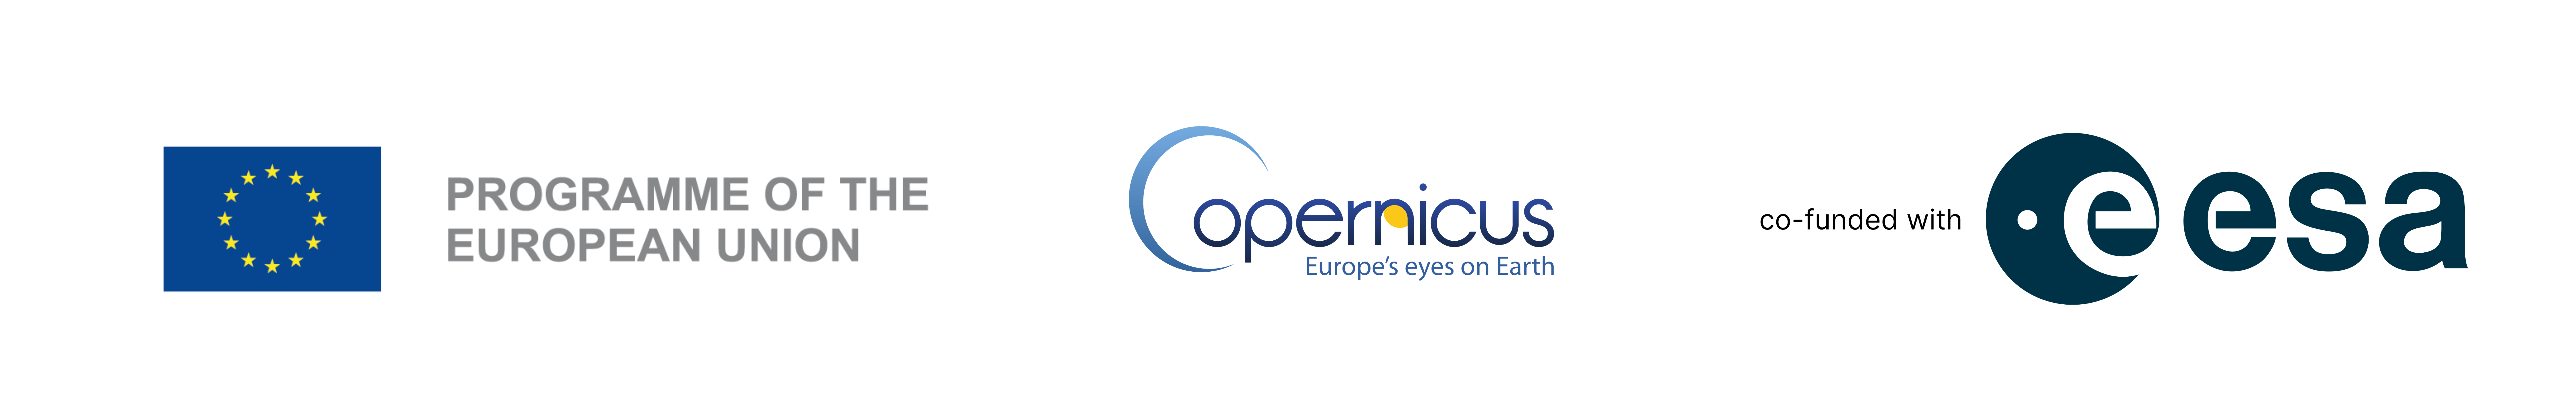